# Zarr store for FLUXNET2015

The [FLUXNET2015 dataset](https://fluxnet.org/data/fluxnet2015-dataset) is an amazing collection of site data from multiple regional flux networks.
The data collection and analysis represents the efforts of hundreds of scientists and technicians around the world, and [has broad applications ranging from ecophysiology studies, remote sensing studies, and development of ecosystem and Earth system models](https://doi.org/10.1038/s41597-020-0534-3).

Usually, to get the data, you would:

1. go to the FLUXNET organization website
2. create an account
3. select the data product, and mark the sites you are interested in
4. agree to the data policy and request the download
5. wait for the download to be prepared
6. click on the download links for every individual site
7. extract the .zip files
8. read in the CSV files

This is not a very streamlined process. Additionally, due to the nature of CSV files, the metadata is included in a separate file and not with the data.

As a demo, we converted part of the "tier one" (CC-BY-4.0 licensed) FLUXNET2015 dataset [to a Zarr store](https://github.com/EXCITED-CO2/zarr-fluxnet2015), which is a community-driven [data format](https://zarr.dev/#description) for chunked, compressed, N-dimensional arrays (such as numpy arrays) based on an open-source specification. Using a Zarr store makes it easier for users to access data and reproduce research.

## Accessing the dataset

Before opening the dataset, you might need to install the following dependencies:

In [ ]:
%pip install xarray zarr aiohttp requests 
%pip install "dask[diagnostics]" --upgrade

To open the data using xarray in Python, we need to specify the link to the zarr store and how the data should be chunked. In this case, we are chunking the data by site:

In [7]:
import xarray as xr

ds = xr.open_dataset(
    "https://excited-co2.github.io/zarr-fluxnet2015/fluxnet.zarr",
    chunks={"time": -1, "site": 1},  # Data is chunked by site
)

## Selecting and displaying data

Once opened, we can view the whole dataset. It includes six variables and their quality flags.
By clicking on the ![attrs_icon.png](../figures/attrs_icon.png) icon, you can view the attributes of a variable.

The dataset level attributes (title, citation, etc.) are listed at the bottom.

In [8]:
ds

<xarray.Dataset> Size: 7GB
Dimensions:    (site: 204, time: 420775)
Coordinates:
  * site       (site) <U6 5kB 'US-Myb' 'CA-SF1' 'US-Twt' ... 'SJ-Blv' 'FR-Pue'
  * time       (time) datetime64[ns] 3MB 1991-01-01T06:00:00 ... 2015-01-01T0...
Data variables:
    gpp_dt     (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    gpp_nt     (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    latitude   (site) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    longitude  (site) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    nee        (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    nee_qc     (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    sw_in      (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    sw_in_qc   (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    ta         (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    ta_qc      (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    vpd        (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
    vpd_qc     (site, time) float64 687MB dask.array<chunksize=(1, 420775), meta=np.ndarray>
Attributes:
    Conventions:             None
    attribution_guidelines:  - Cite the data-collection paper, i.e., cite Pas...
    citation:                Pastorello, G., Trotta, C., Canfora, E. et al. T...
    description:             The FLUXNET2015 Dataset includes data collected ...
    doi:                     https://doi.org/10.1038/s41597-020-0534-3
    history:                 Converted from FULLSET FLUXNET2015 to Zarr on 20...
    license:                 CC-BY-4.0
    title:                   FLUXNET2015 Dataset

We can now access the variables and plot the data using xarray. As an example, here we plot the mean for each day for the "air temperature" variable `ta` for the site "AT-Neu".

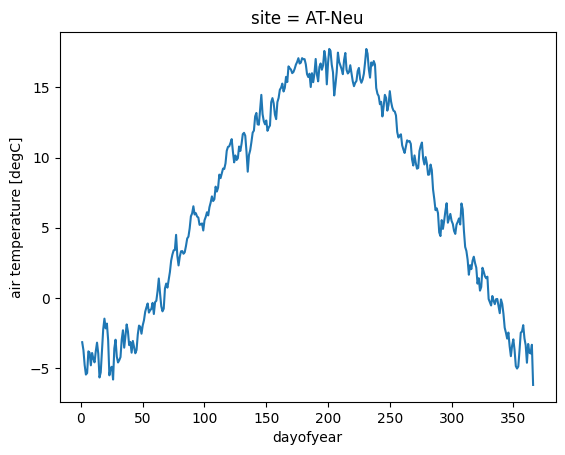

In [10]:
ta_doy = ds["ta"].groupby(ds["time"].dt.dayofyear).mean()  # groupby day-of-year
ta_doy.sel(site="AT-Neu").plot()  # plot for AT-Neu site

We can also use a similar method to plot a scatterplot of one variable against another one. However, this can take some time to run, therefore reducing the data can be helpful. Here we select every 10th site and take the weekly mean to plot air temperature vs. GPP:

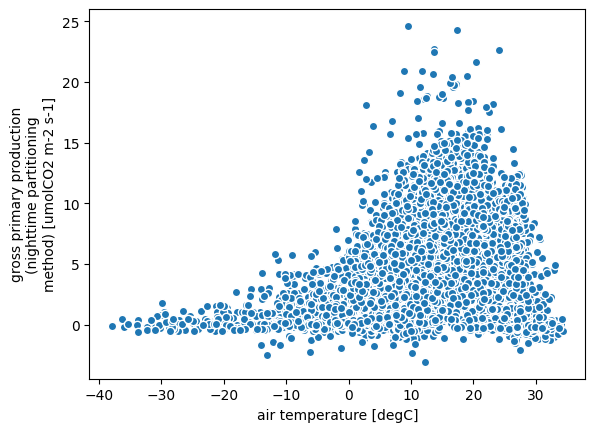

In [11]:
ds_subset = ds.isel(site=slice(None, None, 10))  # take every 10th site for reduced data
ds_subset.resample(time="1W").mean().plot.scatter(x="ta", y="gpp_nt")